# Notebook 3: Data Visualizations 

This notebook explored our datasets through a series of visualizations, ranging from simple scatterplots to static and animated maps. Here we look at case and death rates against a series of our demographic variables that we use as inputs in our model. We also produce a visualization for all US counties that showcases the predictions of the target variable that our model uses. It should be noted that we encountered a lot of constraints in terms of the amount and standardization (or lack thereof) in the Covid-19 data that is made available, and that these constraints should be taken into consideration when interpreting these results. Case rates, for example, are very much contingent on the amount of testing being done, so counties who are doing much less testing might have much lower positive recorded cases than they do in actuality.


In [1]:
import pandas as pd
import geopandas as gpd 
import os 
import matplotlib as plt
import seaborn as sns 
import numpy as np
from IPython.display import HTML
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from zipfile import ZipFile

In [7]:
ZipFile.extractall(path='geo/')

TypeError: extractall() missing 1 required positional argument: 'self'

1.0 Loading in and Cleaning Data For Use in Visualizations
==========

In [2]:
#loading in the prepared county data 
final_all_counties = pd.read_csv('final_all_counties_df.csv')
final_all_counties.shape

(50059, 39)

In [3]:
# restrict to florida counties on static level 
florida_df = final_all_counties[final_all_counties['state'] == 'Florida']
florida_df = florida_df[florida_df['FIPS'] != 12000]

In [4]:
florida_df.shape

(1221, 39)

In [5]:
#Creating population normalized case and death rates for use in visual analysis; grouping by 


groupby_cols = ['FIPS', 'Area_Name','Density per square mile of land area - Population', 
                            'Density per square mile of land area - Housing units', '% Severe Housing Problems', 'Median_Household_Income_2018',
                            'Premature Death', 'Cardiovascular Deaths Per 100K', 'POP_ESTIMATE_2018', 
                            'Average Daily PM2.5','Percent of adults with less than a high school diploma 2014-18',
                            'Employed_2018', 'Unemployment_rate_2018',
                            'Percent_White','Percent_Black', 'Percent_NativeAmerican', 'Percent_Asian',
                            'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic', 'ICU Beds']
                            

per_county_demo = florida_df.groupby(groupby_cols).agg({'m50': 'mean', 
                                                       'm50_index': 'mean', 'cases':'max', 'deaths': 'max'}).reset_index()

per_county_demo['county_deaths_100000'] = (per_county_demo['deaths'] / per_county_demo['POP_ESTIMATE_2018']) * 100000
per_county_demo['county_cases_100000'] = (per_county_demo['cases'] / per_county_demo['POP_ESTIMATE_2018']) * 100000

In [6]:
#making sure we have all of Florida's 67 counties
per_county_demo['Area_Name'].nunique()

67

2.0 Introductory Scatterplot Visualizations of Florida County Data 
==========

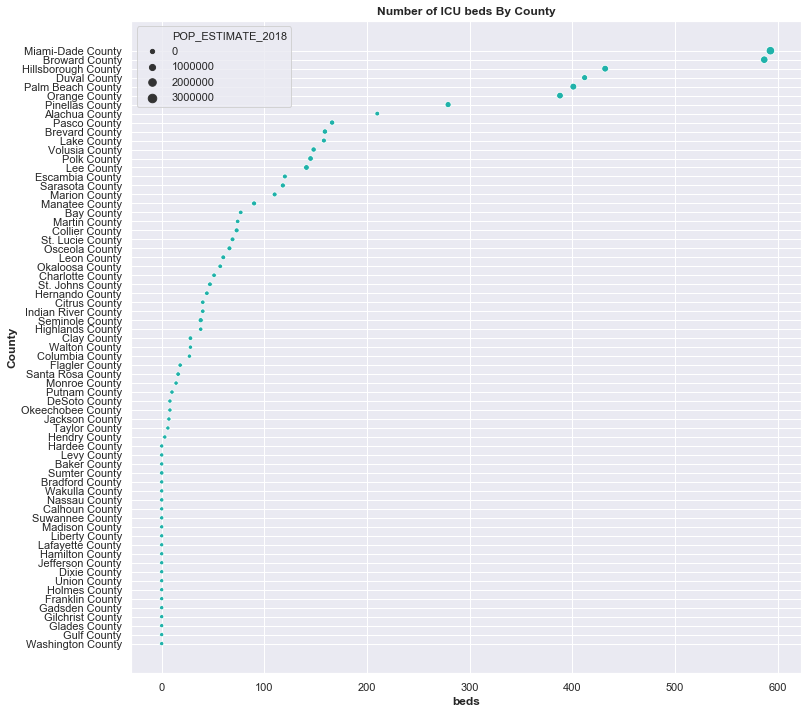

In [7]:
sns.set(rc={'figure.figsize':(12, 12)})

sorted_beds = per_county_demo.sort_values(by='ICU Beds')
beds = sns.scatterplot(x='ICU Beds', y='Area_Name', data = sorted_beds, size="POP_ESTIMATE_2018", color='lightseagreen')
beds.set_title("Number of ICU beds By County", weight='bold') 
beds.set_xlabel("beds", weight='bold')
beds.set_ylabel("County", weight='bold');

This graphs depicts the number of ICU beds per county, with the size of the point representative of the population of that respective county. Unsurprisingly, it appears as though county population is correlated with the number of ICU beds. More surprising was the fact that a significant number of counties don't have any ICU beds at all, and the vast majority have relatively few. 

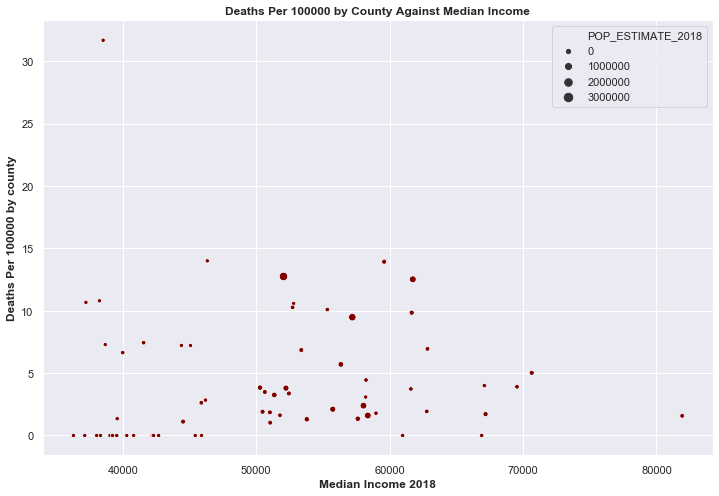

In [8]:
sns.set(rc={'figure.figsize':(12, 8)})

#looking at deaths per 100000 by county median household income 
deaths_100k = sns.scatterplot(x='Median_Household_Income_2018', y='county_deaths_100000', 
                              data = per_county_demo, size='POP_ESTIMATE_2018', 
                              color='maroon')
deaths_100k.set_title("Deaths Per 100000 by County Against Median Income", weight='bold') 
deaths_100k.set_xlabel("Median Income 2018", weight='bold')
deaths_100k.set_ylabel("Deaths Per 100000 by county", weight='bold');

This scatterplot depicts the number of deaths by county against the median income of that county. The size of the point here again represents the population of that county. The results here are murky, and while there appears to be a slight upward trend in the number of deaths as median income increases, this might by more attributle to the size of the county, which would have a substantive impact on income rates.

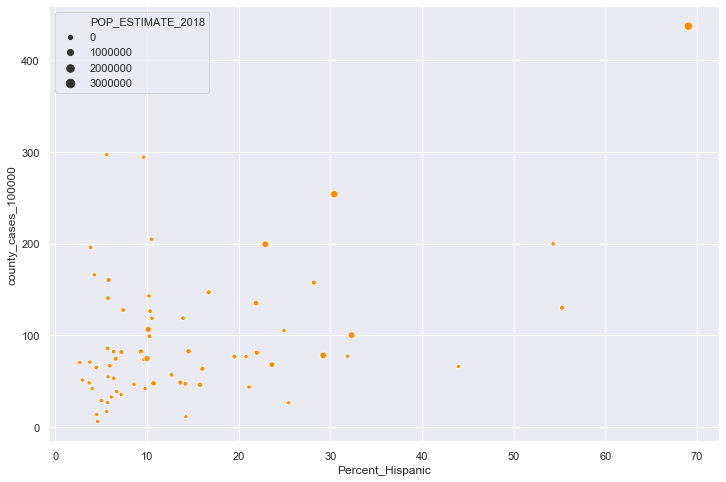

In [9]:
#looking at the case rate by Percent Hispanic by county 
cases_100k = sns.scatterplot(x='Percent_Hispanic', y='county_cases_100000', 
                              data = per_county_demo, size='POP_ESTIMATE_2018', color='darkorange')

This scatterplot depicts the case rate per county against the percent population of that county that is Hispanic. The size of the point here again represents the total population of that county. There appears to be a generally strong upward trend in the case rate per county as the percent of the population that is Hispanic increases. Counties with higher populations also appear to have a larger percent of the population that is Hispanic. 

3.0 Spatial Visualization of Case and Death Rates for Florida Counties
==========

In [11]:
#reading in spatial data for florida  
spatial = gpd.read_file("geo/tl_2017_us_county.shp")
spatial['FIPS'] = spatial['GEOID'].astype('int64')
spatial['STATEFP'] = spatial['STATEFP'].astype('str')
spatial['COUNTYFP'] = spatial['COUNTYFP'].astype('str')
florida_spatial = spatial[spatial['STATEFP'] == '12']


florida_spatial = florida_spatial[['FIPS', 'geometry']]
florida_boundaries = florida_spatial.merge(per_county_demo, on='FIPS', how='left')

In [12]:
florida_boundaries['county_cases_100000']

0      47.153747
1      70.854256
2      53.239930
3      82.551348
4     199.730484
         ...    
62    204.819802
63      6.186587
64     74.529405
65     78.224608
66    127.568947
Name: county_cases_100000, Length: 67, dtype: float64

In [13]:
#linking county coordinates to county names to display in visualization 
florida_boundaries['county'] = florida_boundaries['Area_Name'].str.split().str[0]
florida_boundaries['coords'] = florida_boundaries['geometry'].apply(lambda x: x.representative_point().coords[:])
florida_boundaries['coords'] = [coords[0] for coords in florida_boundaries['coords']]

/Users/Nicolas/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


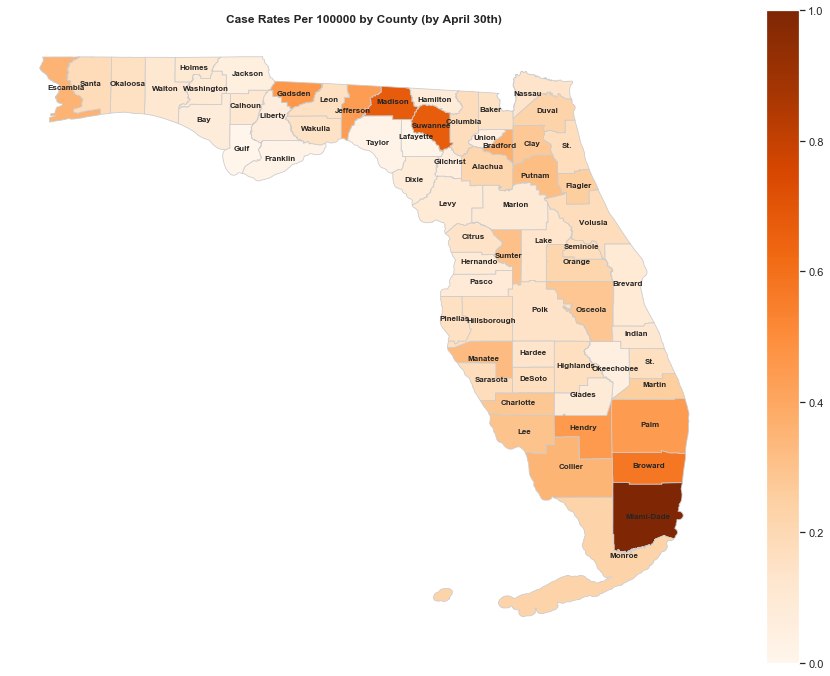

In [14]:
#plotting cases per 100000 by county 
sns.set(rc={'figure.figsize':(16, 12)})
min_val = 0 
case_plot = florida_boundaries.plot(column='county_cases_100000', cmap='Oranges', linewidth=0.8, edgecolor='0.8', 
                                    missing_kwds= {'color':"lightgrey", "hatch": "///", 'edgecolor': 'orange'})
case_plot.axis('off')
case_plot.set_title('Case Rates Per 100000 by County (by April 30th)', weight='bold')
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.colors.Normalize(vmin=min_val))
plt.pyplot.colorbar(sm)
for idx, row in florida_boundaries.iterrows():
    if row['county']: 
        plt.pyplot.annotate(s=row['county'], xy=row['coords'],
                   horizontalalignment='center', fontsize=8, fontweight='bold');

Here we depict Covid Case Rates per 100000 by county as a heatmap. More dense, urban counties like Broward and Miami-Dade have the highest case rates, but they are closely followed by sparsely populated counties like Suwanee (45,000 pop) and Madison (18,000 pop). 

/Users/Nicolas/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


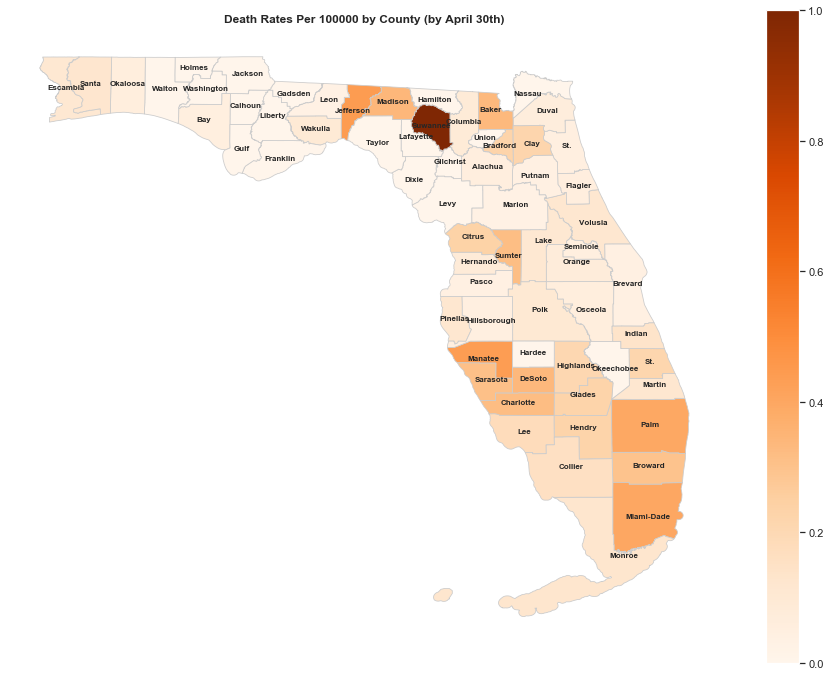

In [15]:
#plotting deaths per 100000 by county 
min_val = 0 
death_plot = florida_boundaries.plot(column='county_deaths_100000', cmap='Oranges', linewidth=0.8, edgecolor='0.8', 
                                    missing_kwds= {'color':"lightgrey", "hatch": "///", 'edgecolor': 'orange'})
death_plot.axis('off')
death_plot.set_title('Death Rates Per 100000 by County (by April 30th)', weight='bold')
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.colors.Normalize(vmin=min_val))
plt.pyplot.colorbar(sm)
for idx, row in florida_boundaries.iterrows():
    if row['county']: 
        plt.pyplot.annotate(s=row['county'], xy=row['coords'],
                   horizontalalignment='center', fontsize=8, fontweight='bold');

This is the same visual as above, with death rates per 100,000 substituting for case rates. It appears as though, unsuprisingly, that counties with higher case rates also see higher death rates as well. The county with the highest death rate is the aforementioned Suwanee, followed by Jefferson (18,000 pop), Manatee (320,000 pop) and the much larger counties like Miami-Dade and Palm. 

4.0 Spatial Visualization of Predictions For US Counties
==========

In [22]:
final_all_counties.shape

(39557, 41)

In [23]:
#loading in the predictions generated by our best model
prediction_all_counties = pd.read_csv('Tables/all_counties_prediction.csv')
prediction_all_counties.shape

(39557, 12)

In [25]:
#drop na's from final dataset, reset index, and reattach predictions 
final_all_counties = final_all_counties.dropna().reset_index()
print(prediction_all_counties.columns)
final_all_counties.loc[:, 'subgroup_case_rate_black'] = prediction_all_counties.loc[:, 'Target Prediction']

Index(['FIPS', 'state', 'Area_Name', 'Date', 'POP_ESTIMATE_2018',
       'Percent_Black', 'cases', 'deaths', 'Target Prediction',
       'Black Population Infected', 'Infection Rate Black',
       'Dif Infection vs Population Rate '],
      dtype='object')


In [26]:
final_all_counties['subgroup_case_rate_black'].describe()

count    39557.000000
mean         0.085249
std          0.067804
min          0.000052
25%          0.054637
50%          0.073535
75%          0.100002
max          0.569425
Name: subgroup_case_rate_black, dtype: float64

In [28]:
#reading in the spatial data 
spatial = gpd.read_file("geo/tl_2017_us_county.shp")
spatial['FIPS'] = spatial['GEOID'].astype('int64')
spatial['STATEFP'] = spatial['STATEFP'].astype('str')
spatial['COUNTYFP'] = spatial['COUNTYFP'].astype('str')

In [29]:
#Dropping Hawaii, Alaska, Puerto Rico, etc... 
contiguous = spatial.drop(spatial[spatial['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78'])].index)
contiguous = contiguous[['FIPS', 'geometry']]

In [30]:
#including counties that are not in the NY times dataset for plotting (these will show up as crosshatched nas)
fip_list = [] 
unique_dates = final_all_counties['Date'].unique().tolist()
for fip in contiguous['FIPS'].unique():
    if fip not in final_all_counties['FIPS'].unique():
        fip_df = pd.DataFrame({'FIPS': [fip for i in range(len(unique_dates))], 'Date': unique_dates})
        final_all_counties = pd.concat([final_all_counties, fip_df], sort=True, ignore_index=True)
        fip_list.append(fip)

In [31]:
#merging the all counties data and predictions with the spatial data 
fc_spatial = contiguous.merge(final_all_counties, on='FIPS', how='left')
fc_spatial['Date'].astype('str')
fc_spatial.shape

(52035, 43)

In [32]:
#setting outpath path to redirect graphs 
output_path = 'Figures'

In [33]:
#creating series of temporal graphs for use in animated gif -- creates one for every day
for date in unique_dates: 
    fcsp = fc_spatial[fc_spatial['Date'] == date]
    
    case_plot = fcsp.plot(column='subgroup_case_rate_black', cmap='OrRd', linewidth=0.8, edgecolor='0.8', 
                                    missing_kwds= {'color':"lightgrey", "hatch": "///", 'edgecolor': 'orange'})
    case_plot.axis('off')
    case_plot.set_title('Black COVID-19 Cases as a Proportion of Total Black Population', weight='bold', fontsize=25)
    case_plot.annotate(date, xy=(0.1, .225), xycoords='figure fraction', 
                      horizontalalignment='left', verticalalignment='top', 
                      fontsize=20)
    filepath = os.path.join(output_path, date +'_rate.png')
    chart = case_plot.get_figure()
    chart.savefig(filepath, dpi=300)
    plt.pyplot.close()
    

In [34]:
#Behind the scenes disclosure: converted pngs to jpg and ran through 
#gif converter to create dynamic image 
HTML('<img src="trial.gif">')

This gif animates 17 charts that were created for each day in our dataset. The variable we use here is our predicted variable (subgroup_case_rate_black), and as we have no means to verify our results for the all-county dataset, this visual should be taken in with extreme caution. As the case rate is cumulative, most counties move to a darker shade over time. A large portion of the counties aren't reporting data - these are represented by the crosshatched orange lines with a grey background. The Southwest and Southeast have numerous counties that stand out as explicit high points, but due to the limitations of our model and that of Covid-19 data more generally, this is worthy simply of inspiring further inspection, not firm conclusions. 